Multi-Qubit Error Mitigation Analysis



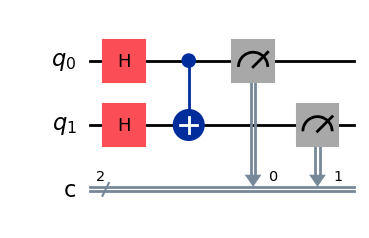

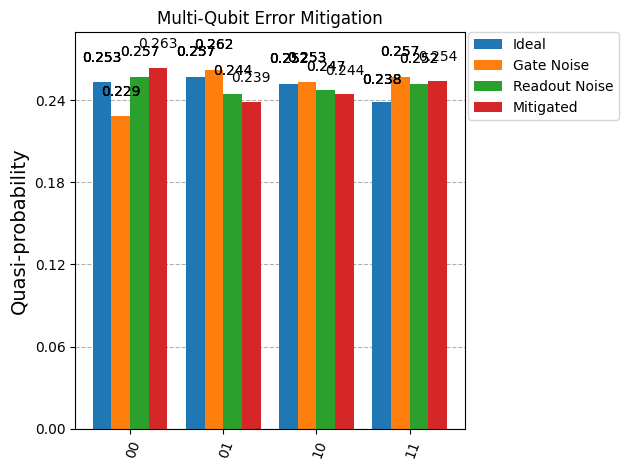

Summary
-------
Qubits        : 2
Noise Strength: 0.12
Shots         : 1024
Mitigation    : Classical Readout Inversion

⚠ IBM Quantum hardware execution requires:
• IBM Quantum account
• API token setup
• Queue wait time
Recommended for final validation, not demos.


In [5]:
# ==========================================================
# Quantum Error Mitigation & Hardware Comparison Lab
# ==========================================================

!pip install qiskit qiskit-aer ipywidgets matplotlib pylatexenc --quiet

# ----------------------------------------------------------
# Imports
# ----------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error
from qiskit.visualization import plot_histogram

# ----------------------------------------------------------
# Noise Models
# ----------------------------------------------------------
def gate_noise(p):
    noise = NoiseModel()
    # 1-qubit depolarizing error for single-qubit gates
    error_1q = depolarizing_error(p, 1)
    noise.add_all_qubit_quantum_error(error_1q, ["h", "x"])
    # 2-qubit depolarizing error for two-qubit gates
    error_2q = depolarizing_error(p, 2)
    noise.add_all_qubit_quantum_error(error_2q, ["cx"])
    return noise

def readout_noise(p, n):
    ro = ReadoutError([[1-p, p], [p, 1-p]])
    noise = NoiseModel()
    for q in range(n):
        noise.add_readout_error(ro, [q])
    return noise

# ----------------------------------------------------------
# Multi-Qubit Circuit
# ----------------------------------------------------------
def build_circuit(n):
    qc = QuantumCircuit(n, n)
    for i in range(n):
        qc.h(i)
    for i in range(n-1):
        qc.cx(i, i+1)
    qc.measure(range(n), range(n))
    return qc

# ----------------------------------------------------------
# Measurement Error Mitigation
# ----------------------------------------------------------
def mitigate_counts(counts, p, shots):
    corrected = {}
    for k, v in counts.items():
        prob = v / shots
        prob = (prob - p) / (1 - 2*p)
        corrected[k] = max(prob, 0)
    norm = sum(corrected.values())
    return {k: v/norm*shots for k, v in corrected.items()}

# ----------------------------------------------------------
# Main Analysis
# ----------------------------------------------------------
def run_analysis(n, noise_p, shots, hardware):
    clear_output(wait=True)
    print("Multi-Qubit Error Mitigation Analysis\n")

    qc = build_circuit(n)
    display(qc.draw("mpl"))

    ideal_sim = AerSimulator()
    noisy_sim = AerSimulator(
        noise_model=gate_noise(noise_p)
    )
    readout_sim = AerSimulator(
        noise_model=readout_noise(noise_p, n)
    )

    ideal = ideal_sim.run(qc, shots=shots).result().get_counts()
    noisy = noisy_sim.run(qc, shots=shots).result().get_counts()
    readout = readout_sim.run(qc, shots=shots).result().get_counts()

    mitigated = mitigate_counts(readout, noise_p, shots)

    display(plot_histogram(
        [ideal, noisy, readout, mitigated],
        legend=["Ideal", "Gate Noise", "Readout Noise", "Mitigated"],
        title="Multi-Qubit Error Mitigation"
    ))

    print("Summary")
    print("-------")
    print(f"Qubits        : {n}")
    print(f"Noise Strength: {noise_p}")
    print(f"Shots         : {shots}")
    print("Mitigation    : Classical Readout Inversion")

    if hardware:
        print("\n⚠ IBM Quantum hardware execution requires:")
        print("• IBM Quantum account")
        print("• API token setup")
        print("• Queue wait time")
        print("Recommended for final validation, not demos.")

# ----------------------------------------------------------
# UI / UX
# ----------------------------------------------------------
qubits = widgets.IntSlider(value=2, min=2, max=3, step=1, description="Qubits")
noise = widgets.FloatSlider(value=0.05, min=0.0, max=0.3, step=0.01, description="Noise")
shots = widgets.IntSlider(value=1024, min=256, max=4096, step=256, description="Shots")
hardware = widgets.Checkbox(False, description="Compare with IBM Hardware")

run_btn = widgets.Button(description="Run Analysis", button_style="success")

run_btn.on_click(lambda b: run_analysis(
    qubits.value, noise.value, shots.value, hardware.value
))

display(
    widgets.VBox([
        widgets.HTML("<h2 style='text-align:center;'>⚛️ Quantum Error Mitigation Lab</h2>"),
        widgets.HTML("<p style='text-align:center;'>Multi-Qubit | Noise-Aware | Hardware-Ready</p><hr>"),
        qubits,
        noise,
        shots,
        hardware,
        run_btn,
        widgets.HTML("<hr><p style='font-size:0.8em; text-align:center;'>NISQ-era mitigation & benchmarking</p>")
    ])
)